In [ ]:
!pip install yfinance
!pip install torchsummaryX
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import datetime
import yfinance as yf
import numpy as np
import pandas as pd

from arch import arch_model
from arch.__future__ import reindexing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
                     'Log Adj Close', 'Log Return', 'Log Volume', 'Log Volume Chg', 'Log Range', '10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * self.scaling_factor
        data["Log Volume"] = np.log(data["Volume"])
        data["Log Volume Chg"] = np.insert(np.diff(data["Log Volume"]), 0, 0)
        data["Log Range"] = np.log(data["High"] / data["Low"]) * self.scaling_factor
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        data["30-day-vol"] = data["Log Return"].rolling(30).std(ddof=0)

        return data

    def get_vix_data(self):
        """
        Output:
        raw vix data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        """
        data = yf.download("^VIX", start = self.start, end = self.end, interval = self.freq)
        
        return data

    def prepare_data(self, *args):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Input:
        Multiple types of data:
        Basic data: 10-day-vol, Log Volume Chg, Log Range
        Optional data: VIX?

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization

        Current features:
        [10-day-vol, Log Return, Log Volume Chg, Log Range, 30-day-vol, VIX]
        Update based on correlation [10-day-vol, Log Range, 30-day-vol, VIX]
        """
        data = args[0]
        vol_10 = data['10-day-vol'].values.reshape(-1, 1)
        log_return = data['Log Return'].values.reshape(-1, 1)
        log_vlmchg = data['Log Volume Chg'].values.reshape(-1, 1)
        log_range = data['Log Range'].values.reshape(-1, 1)
        vol_30 = data['30-day-vol'].values.reshape(-1, 1)
        
        dataset = vol_10
        # dataset = np.append(dataset, log_return, axis=1)
        # dataset = np.append(dataset, log_vlmchg, axis = 1)
        dataset = np.append(dataset, log_range, axis = 1)
        dataset = np.append(dataset, vol_30, axis = 1)
        
        # For appending more types of data -> VIX
        for i in range(1, len(args)):
            extra_data = args[i]['Adj Close'].values.reshape(-1, 1)
            dataset = np.append(dataset, extra_data, axis = 1)

        dataset = dataset[31:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, vol_10, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
print(np.shape(data))

[*********************100%***********************]  1 of 1 completed
(8301, 13)


In [ ]:
class Garch:
    def __init__(self, data, train_pct):
        self.data = data
        self.train_pct = train_pct
        self.prediction = None
        self.target = None
      
    def train(self):
        data = self.data["Log Return"]
        train_data = data[:round(np.shape(data)[0] * self.train_pct)]
        
        bic_garch = []
        best_param = (1, 1)
        for p in range(1, 10):
            for q in range(1, 10):
                garch = arch_model(train_data, mean='zero',vol='GARCH', p=p, o=0, q=q).fit(disp='off')
                bic_garch.append(garch.bic)
                if garch.bic == np.min(bic_garch):
                    best_param = (p, q)
                    
        return best_param

    def predict(self, test_size):
        rolling_predictions = []

        (p, q) = self.train()
        print("best (p, q): ", "(", p, ",", q, ")")

        for i in range(test_size - 10):
            train_data = self.data["Log Return"][:-(test_size-i)]
            model = arch_model(train_data, mean='zero', vol='GARCH', p=p, o=0, q=q)
            model_fit = model.fit(disp='off')
            pred = model_fit.forecast(horizon=10)
            rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][-1]))

        rolling_predictions = pd.Series(rolling_predictions, index=self.data["Log Return"].index[-test_size+10:])
        
        return rolling_predictions

    def compare(self, test_size):
        realized_vol = self.data["Log Return"].rolling(10).std(ddof=0)[-test_size+10:]
        predicted_vol = self.predict(test_size)
        self.target = realized_vol
        self.prediction = predicted_vol
        print(realized_vol)
        print(predicted_vol)
        print("MSE: ", np.sqrt(mean_squared_error(realized_vol, predicted_vol)))
        print("MSE: ", np.nanmean(np.square(realized_vol - predicted_vol)))

        plt.figure(figsize=(10,6))
        plt.plot(realized_vol, label='Realized Volatility')
        plt.plot(predicted_vol, label='Predicted Volatility - GARCH')
        plt.title('Volatility Prediction with GARCH', fontsize=12)
        plt.legend()
        plt.show()

best (p, q):  ( 2 , 1 )
Date
2013-02-06    0.640225
2013-02-07    0.645756
2013-02-08    0.647245
2013-02-11    0.642840
2013-02-12    0.629625
                ...   
2022-12-05    1.314086
2022-12-06    1.388753
2022-12-07    1.311427
2022-12-08    1.321578
2022-12-09    1.331628
Name: Log Return, Length: 2480, dtype: float64
Date
2013-02-06    0.767033
2013-02-07    0.745052
2013-02-08    0.722844
2013-02-11    0.718007
2013-02-12    0.700395
                ...   
2022-12-05    1.654621
2022-12-06    1.562107
2022-12-07    1.474683
2022-12-08    1.450670
2022-12-09    1.381014
Length: 2480, dtype: float64
MSE:  0.2780232368007427


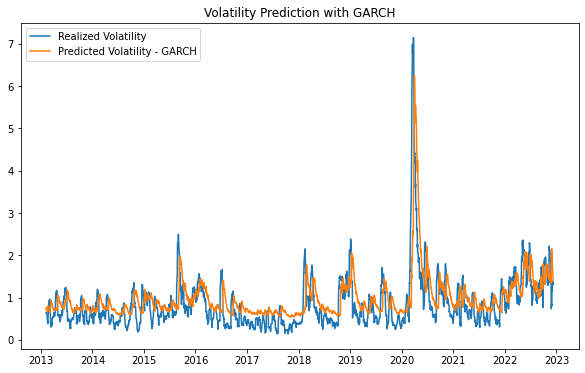

In [ ]:
garch = Garch(data, 0.7)
garch.compare(round((1 - garch.train_pct) * np.shape(garch.data)[0]))

In [ ]:
len(garch.prediction)

2480

In [ ]:
# from google.colab import drive
# import 
# drive.mount('/content/drive')



In [ ]:
# import csv

# with open('GARCH_pred.csv', 'w') as file:
#     writer = csv.writer(file)
#     writer.writerow(predicted_vol)

# New Section